<b><font size=20, color='#A020F0'>Dask</font></b>

Hannah Zanowski<br>
11/21/22

#### <span style="color:green">Learning Goals</span>
By the end of this notebook you will
1. Become familiar with the different components of the dask package
2. Practice using dask for geoscience data analysis
3. Understand some of the challenges of working with big data and dask

#### Resources
[Dask Website](https://www.dask.org/)<br>
[Dask Documentation](https://docs.dask.org/en/stable/)<br>
[Dask Best Practices](https://docs.dask.org/en/stable/best-practices.html)

#### Acknowledgements
Parts of today's lecture have been adapted and or borrowed (with permission) from Dr. Elizabeth Maroon's Dask tutorial from 2021

Major thanks to Brian Aydemir of the [Morgridge Institute for Research](https://morgridge.org/) and Christina Koch at the UW-Madison [Center for High Throughput Computing](https://chtc.cs.wisc.edu/) for setting up a jupyterhub specifically for this lecture.

# A little about Dask

Dask is a package developed to make parallel computing more straightforward and accessible to a broad range of people, and it does so by extending standard python data analysis tools so that they can be applied in highly complex and voluminous data processing situations. Dask is especially useful when dealing with big data or doing computations that don't need to be done in serial.

Let's begin by importing a few packages that we'll need today:

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

---

## 1. Some Terminology

From good ol' Wikipedia:<br>

<b><font color='navy'>Big Data:</font></b>"Big data refers to data sets that are too large or complex to be dealt with by traditional data-processing application software"

<b><font color='navy'>Parellel Computing:</font></b>"Parallel computing is a type of computation in which many calculations or processes are carried out simultaneously"

<b>Many geoscientific datasets and projects qualify as big data. Here are some examples: </b> 
>1. Model Intercomparison Projects (MIPs), 
>2. Ensemble forecasts and simulations, 
>3. "High resolution" simulations
>4. Real-time Earth system observations (e.g., satellite retrievals, weather stations, Argo)
>5. Field campaigns with multiple platforms

A traditional workflow for processing a dataset might look something like this: 
>1. Read file into memory
>2. Compute (data reduction)  
>3. Write result to file or display figure

What happens if a file is larger than the available memory? What if the computation requires the full data along one dimension but the files are split along that dimension? For example, say you want to calculate a climatology, but you have files for each year and you can't load them all into memory at once. What do you do then?

That's where dask comes in!

---

## 2. The basics of Dask

### Dask Arrays
[Dask arrays](https://docs.dask.org/en/stable/array.html#array) are a core data structure in dask. They are analagous to the standard numpy arrays you are used to, except that they don't hold any data in them. We'll go through this below.

First, let's import dask.array:

In [2]:
import dask.array as da

As an example, let's create a small dask array of ones:

In [3]:
shape=(4000,1000)
ones=da.ones(shape)

Now let's look at the output:

In [4]:
ones

dask.array<ones_like, shape=(4000, 1000), dtype=float64, chunksize=(4000, 1000), chunktype=numpy.ndarray>

Great! So what does this mean? Let's break it down below.

<b>Interpreting your dask.array object:</b>

Column Information from the Table:
>1. <b><font color='navy'>Array:</font></b> Describes information about your dask.array object
>2. <b><font color='navy'>Chunk:</font></b> Describes information about the chunks that your dask.array object is split into

Row Information from the Table:
>1. <b><font color='navy'>Bytes:</font></b> The size of the array or chunk, in this case in Mebibytes
>2. <b><font color='navy'>Shape: </font></b> The dimensions of the array or chunk
>3. <b><font color='navy'>Dask Graph: </font></b> The number of chunks + graph layers associated with the array
>4. <b><font color='navy'>Data Type: </font></b> The data type of the array

Our ones array takes up ~30.5 MiB in memory (uncompressed). There is one chunk that is the size of the whole variable (30.5 MiB).

><b><font color='darkmagenta'>Note:</font></b> A MiB (Mebibyte, 1024^2 bytes) is not the same as a MB (Megabyte, 1000^2 bytes), but for our purposes it's ok to think of them as the same.

Let's talk a little more about chunks below.

#### Chunking
An important part about working with dask.array objects is specifying how you want your data to be split up for computations. That's where the `chunks` argument comes in. Chunks really means <b>chunk shape</b>, so you want to specify the sizes of all of the dimensions in your array. Below we'll split our ones array of shape (4000,1000) into 4 equally sized chunks with dimensions (1000,1000):

In [5]:
chunk_shape=(1000,1000)
ones=da.ones(shape,chunks=chunk_shape)
ones

dask.array<ones_like, shape=(4000, 1000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

#### Setting up a computation
Setting up a computation is much the same as it is with normal numpy arrays--you apply whatever functions you want to your data. Below we'll take the sum of our ones dask.array object:

In [6]:
%%time
ones_sum=ones.sum()

CPU times: user 2.27 ms, sys: 98 µs, total: 2.37 ms
Wall time: 2.36 ms


#### Visualizing your computation
Notice that the previous cell finished in milliseconds. This is because the sum has not been calculated yet: 

In [7]:
ones_sum

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

So what is this? If you notice, the array size changed as well as the chunks and the number of tasks. 

As with the dask array we created above, here we've created a "delayed object" that will be computed when necessary. This feature in dask is known as <b>lazy computing.</b> 

Below we'll use [graphviz](https://pypi.org/project/graphviz/) to see what our object actually looks like:

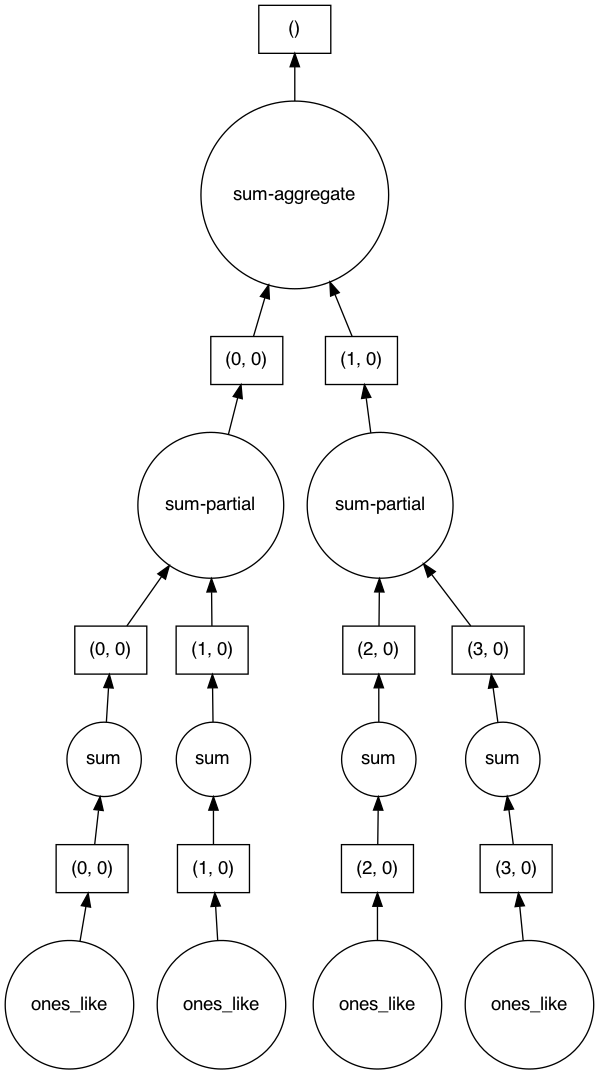

In [8]:
ones_sum.visualize()

What you see here is a task graph, or a road map of what the computation will look like once it is triggered, <b>but no computation has occurred yet!</b>

#### Triggering Computations
There are several ways in which you can trigger a computation so that dask will reduce your arrays and make the result available in memory:

>1. [compute()](https://docs.dask.org/en/stable/generated/dask.array.Array.compute.html): tells dask to compute the task graph immediately
>2. [persist()](https://docs.dask.org/en/stable/generated/dask.array.Array.persist.html#dask-array-array-persist): the computation is executed in the background when it can

Plotting also always triggers a computation, as you need the actual output available in memory in order to make a plot!

In [9]:
ones_sum.compute()

4000000.0

#### Example 2: A heftier computation
In the previous example, the size of the array we created was small (~30MB). <b>We'd really never use dask for such a computation</b>, so in the example below we'll create a new dask array of ones that is significantly larger.

><b><font color='red'>Note:</font></b> Using dask for data that is too small can actually have the opposite effect and make things slower!

In [10]:
chunk_shape=(200,100,500)
ones_again=da.ones((2000,1000,5000),chunks=chunk_shape)
ones_again

dask.array<ones_like, shape=(2000, 1000, 5000), dtype=float64, chunksize=(200, 100, 500), chunktype=numpy.ndarray>

The dask array we created is ~74GB, which is larger than the available memory each of you has at your disposal on the jupyterhub. If you tried to create this array normally (without dask), it would likely crash your session. Nevertheless, we can use dask to do computations on this array even though we can't read the entire thing into memory at once. 

><b><font color='red'>WARNING: </font> DO NOT </b> compute a task graph for this computation! Attempting to render large graphs can take forever or crash your system!

The chunks we have are much smaller, ~76MB, so when we got to compute, dask will work on the chunks individually:

In [11]:
#give us a progress bar when we compute
from dask.diagnostics import ProgressBar

#Set up a calculation
ones_calculation=np.cos(ones_again*np.pi/3).mean()

#Do the calculation
with ProgressBar():
    calc=ones_calculation.compute()
calc

[########################################] | 100% Completed | 14.36 s


0.5000000000000001

---

## 3. Xarray and Dask
In the examples that follow we'll be using hourly [ERA5](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5) potential vorticity (PV) data on a 0.25˚x0.25˚ grid for the month of August 2022. Data were downloaded [here](https://rda.ucar.edu/thredds/catalog/files/g/ds633.0/e5.oper.an.pl/202208/catalog.html) from the UCAR/NCAR Research Data Archive

As I have alluded to in previous lectures, [Xarray is designed to work with dask](https://examples.dask.org/xarray.html). You can make _any_ xarray dataset a dask array by simply specifying a `chunks` argument in calls to [open_dataset](https://docs.xarray.dev/en/stable/generated/xarray.open_dataset.html). The chunks keyword in xarray is specified as a dictionary that describes how you want the dataset broken up:

In [ ]:
path='/data/aos573/'
ds=xr.open_dataset(path+'e5.oper.an.pl.128_060_pv.ll025sc.2022080100_2022080123.nc',chunks={})
ds.PV

Anytime you use [open_mfdataset](https://docs.xarray.dev/en/stable/generated/xarray.open_mfdataset.html#xarray-open-mfdataset), xarray also automatically uses dask:

In [ ]:
ds=xr.open_mfdataset(path+'*.nc',chunks={'time':1})
ds.PV

As a limited example, let's take the time mean of the PV for only the first 24 hours of data and plot it at 500 hPa. 

><b><font color='blue'>Note:</font></b> When using dask with xarray, you can also trigger computations using `.load()` in addition to `.compute()` or `.persist()`

In [ ]:
%%time
pvmn=ds.PV.sel(time=slice('2022-08-01T00','2022-08-01T23')).mean(dim='time')
pvmn.sel(level=500).plot()

At a low traffic time on the jupyterhub, this calculation takes me about 6 seconds. Let's compute approximately how much time it would take to calculate an average for the entire month of August:
>6 seconds/day * 31 days/month = 186 seconds or ~3 min to process a month of data with 31 days

<b>Now imagine you wanted to get monthly mean values for the entire ERA5 dataset up through the end of 2021 (so 1959-2022 or 63 years of data).</b> For simplicity well assume that each month has 30 days:
>6 seconds/day * 30 days/month * 12 months/year * 63 years = 136080 seconds or ~38 hours

You _could_ just submit this job to run in the background on a server and go work on whatever else you need to accomplish. But that's assuming your code works and your script does not get interrupted in the mean time. Chances are, though, that even if your code runs, you will have made some kind of mistake the first few times through, which means you will need another day and a half to run your code (and perhaps another, and another after that).

#### <font color='red'>If that doesn't make you feel concerned, it should!</font>
    
Part of the issue is that we didn't think too critically about our chunking strategy, so much so that if we read in the data and did the computation without dask, it would take a similar amount of time.

### More on chunking
How do you actually decide what a good chunk size is? Like many things we've learned this semester, choosing a good chunk size is an art, so you should expect some amount of trial and error when figuring it out. 

<b>Here are a few guidelines to follow:</b>
>1. The dask developers state optimal chunk size should be in the ~10-100 MB range. 
>2. Once you've finished all of your data reduction steps, check the number of tasks and try to keep that number as minimal as possible. If you've got 10,000-100,000 tasks, you've probably got too many.   
>3. Set your chunk strategy based upon the dimensions that you will be reducing along

We'll go through an example below to help you practice thinking about some of these things. Using 10 days of ERA5 output, we're going to calculate daily values of mean PV over (roughly) the contiguous U.S. in two different ways: 

><b>Method 1:</b> Calculate the spatial mean at each time and then calculate the daily means <br>
><b>Method 2:</b> Calculate the daily means at each grid point and then calculate the spatial mean

First, let's read in our data with slightly different chunks:

In [ ]:
ds=xr.open_mfdataset(path+'*.nc',chunks={'time':12, 'level':1})
ds.PV

Method 1:

In [ ]:
%%time
pv_slice=ds.PV.sel(latitude=slice(70,50),longitude=slice(70,125))
pv1=pv_slice.mean(dim=('longitude','latitude')).groupby('time.day').mean('time').load()

Method 2:

In [ ]:
%%time
pv_slice=ds.PV.sel(latitude=slice(70,50),longitude=slice(70,125))
pv2=pv_slice.groupby('time.day').mean('time').mean(dim=('longitude','latitude')).load()

#### Question for the class
Why do these computations take different amounts of time?

---

## 4. Distributing your computations across multiple cores

### dask.distributed

By default dask computes each chunk in series rather than in parallel. If you want to change that behavior, that's where [dask.distributed](https://distributed.dask.org/en/stable/) comes in--it allows us to spread our processes over multiple cores, so that multiple dask chunks can be operated upon simultaneously. 

Let's import what we need from dask.distributed:

In [12]:
#import dask.distributed methods
from dask.distributed import Client, LocalCluster

In our case we are going set up a [local cluster](https://distributed.dask.org/en/stable/api.html#cluster) with 1 thread per worker (1 worker = 1 core), 2 GB memory per worker, with 4 workers. 

Each of you has 8 cores and a total of 16GB of memory available on the jupyterhub we are working on, but we don't want to set up a cluster that uses all of the available memory.

<b>Some important arguments in `LocalCluster`:</b>
>1. <b><font color='navy'>threads_per_worker:</font></b> how many processors are part of each worker. 
>2. <b><font color='navy'>memory_limit:</font></b> the memory assigned to each worker.  Total memory available = n_workers*memory_limit

We have 4 cores x 2GB = 8GB for the memory limit. 

In [13]:
cluster = LocalCluster(memory_limit='2GB', threads_per_worker=1)

Once we specify the memory limit and threads per worker, we have two options for how to scale the cluster. We can make it adaptive (the number of workers used scales with the amount of work to be done at the time) or we can reserve a static number of processes:

In [ ]:
cluster.scale(4)  # scale cluster to use 4 workers

#OR
#Allow your cluster to scale to a max of 4 workers, always with a min of 1 worker:
#cluster.adapt(minimum=1, maximum=4)  

After our cluster is set up, we need to set up a [client](https://distributed.dask.org/en/stable/api.html#client). The client does the job of assigning our dask chunks to specific workers in our cluster:

In [ ]:
client=Client(cluster)

In [ ]:
client

#### Dask widgets
Click on the Launch dashboard in Jupyterlab button above to see what shows up. There are a bunch of tools here, and as you become more familiar with dask, several of them will be useful. We'll mostly use the [task stream](https://distributed.dask.org/en/stable/diagnosing-performance.html#task-start-and-stop-times) (assuming it decides to show up today). 

#### Another example
Let's go through another example to get used to working with a dask cluster. In this example we're going to read in all of the hourly August data from a thredds server instead (so we don't have to download it locally) and then do a computation that doesn't allow us to do much data reduction:

In [ ]:
%%time 
#import TDScatalog from siphon
from siphon.catalog import TDSCatalog
#get the thredds catalog
cat=TDSCatalog('https://rda.ucar.edu/thredds/catalog/files/g/ds633.0/e5.oper.an.pl/202208/catalog.xml')
#get the data we want
data=[cds.access_urls['OPENDAP'] for cds in cat.datasets[1:62:2]]
#open the data
ds=xr.open_mfdataset(data,chunks={'time':12,'level':1})

#Alternate if siphon refuses to play nice in time
#path='/data/aos573/'
#ds=xr.open_mfdataset(path+'*.nc',chunks={'time':12, 'level':1})

In [ ]:
ds.PV

Let's compute the meridional PV gradient of the 3-hourly mean fields. Because of the nature of our calculation, we aren't reducing any of the spatial dimensions, so we'll reduce time first and then do the gradient calculation:

In [ ]:
#Resample
pv_resample=ds.PV.resample({'time':'3H'}).mean()

#Compute the gradient
dy=6371000*0.25*np.pi/180 #compute dy first (grid is evenly spaced)
#Keep track of the fact that latitude in ERA5 starts at 90 not -90, so lat is decreasing, and hence y
dy=-dy
pv_grad=pv_resample.diff(dim='latitude')/dy

Let's look at what the size of our computed output will be _before_ we compute it:

In [ ]:
pv_grad

In [ ]:
%%time
#Plot
pv_grad_slice=pv_grad.sel(level=500,time='2022-08-01T00')
pv_grad_slice.plot(vmin=-0.05e-10,vmax=0.05e-10)

### Using functions that aren't built for xarray/dask

Because xarray is built upon dask, all xarray functions will parallelize if dask has been invoked. This isn't necessarily the case for more complicated functions built upon normal numpy arrays. To allow these kinds of functions to scale and use dask, there are a couple of methods that can help:

>1. [xarray.apply_ufunc()](http://xarray.pydata.org/en/stable/generated/xarray.apply_ufunc.html): apply_ufunc() allows you to apply generic functions to xarray objects
>2. [dask.array.map_blocks](https://docs.dask.org/en/latest/generated/dask.array.map_blocks.html) and [xarray.map_blocks](http://xarray.pydata.org/en/stable/generated/xarray.map_blocks.html#xarray.map_blocks
): these can be useful for blocking and operating on objects that aren't built on dask arrays already 

><font color='red'><b>Note:</b></font> It can be very challenging to figure out how to use `apply_ufuncs()` and `map_blocks()` in specific cases!

Below I'll demonstrate an example using `apply_ufuncs`. We'll take the [np.gradient](https://numpy.org/doc/stable/reference/generated/numpy.gradient.html#numpy-gradient) function and apply it to our PV fields:

In [ ]:
#Set up the function
def grad(da, dim, grid_delta):
    #remember that apply ufunc moves input core dimensions to end
    #of array
    return xr.apply_ufunc(np.gradient, da, grid_delta, kwargs={'axis': -1},
            input_core_dims=[[dim], []], output_core_dims=[[dim]],
            output_dtypes=[da.dtype],dask = 'parallelized')

To demonstrate the functionality, we'll get a single level and time from the data giving us one 2D field:

In [ ]:
pv_slice=ds.PV.sel(level=500,time='2022-08-01T00')

In [ ]:
%%time
pv_grad=grad(pv_slice,dim='latitude',grid_delta=-dy) #lat is decreasing from start to finish
pv_grad.load()

In [ ]:
pv_grad.T.plot(vmin=-0.05e-10,vmax=0.05e-10)

### <font color='red'> When you're all done with your distributed computations you must shut down the client and close the cluster:</font>


In [14]:
client.shutdown()  #order matters, stop the client then the cluster
cluster.close()

NameError: name 'client' is not defined

---

## 5. The rules of the road

#### <p style="border-width:3px; border-style:solid; border-color:darkmagenta; padding: 1em;"><font color='purple'>"With great dask power comes great dask responsibility"</font><br><font size=2 color='gray'>Elizabeth Maroon</font></p>
<b>Dask can lead to significant speedups in your work, but it's very easy to mess things up for both you AND others. </b>

If you are on a relatively small server, it is easy to accidentally scale your dask cluster to the entire server and slow/crash everyone else's processes! Or, maybe you accidentally scale to use up all the memory, and crash the server. 

<b>In general, it's best to keep the following in mind when using dask:</b>

>1. Don't use dask just because you can, use it when it's actually necessary. If your data are not huge, it may be more cost-efficient for your time to use more traditional methods and skip dask
>2. AVOID USING DASK ON THE 14th FLOOR MACHINES or the AOS jupyterhub. USE DASK ON GROUP RESEARCH SERVERS INSTEAD
>3. Be <b>very deliberate</b> in setting up the memory and number of cores that you're using. Don't persist/load an entire dataset into memory. 
>4. When doing exploratory analysis, use cluster.adapt() rather than cluster.scale() to minimize the time when a maximum number of workers are used
>5. <b><font color='red'>Don't take over an entire system!!</font></b>--run top in a terminal to check on your dask processes to make sure that this isn't happening. It also helps to know the specifications of the system you are working on so that you don't get near this limit.

<b> Regardless of the platform, always be a polite compute user and be aware of those also using computational resources.</b> 